# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM


# S190521g

In [32]:
# Define events with start times and observation MJD times
events = {
    "S190521g": {
        "total_mass" : 100.0,
        "redshift": 0.438,
        "dL": cosmo.luminosity_distance(0.438).to(u.Mpc).value,
        "start": '2019-05-19 00:00:00',
    }
}


In [33]:
event_total_mass = [events[key]["total_mass"] for key in events.keys()]
event_total_mass = np.array(event_total_mass)
event_total_mass 

array([100.])

Model functions

In [34]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, a, aspect_ratio, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (a / 700) 
        * (M_SMBH / 10**8)
        * (aspect_ratio / 0.01)
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [35]:
# Specific kick configurations

vk1 = 200 

# Density of the disk
density = 10**(-10) 

# t_delay for emergence of EM signal
sig_start_times_1 = t_ram(event_total_mass, vk1)  # in days


# diffusion timescale for EM signal to emerge

mass_SMBH =  10**8 # depends on the mass of the SMBH
a = 700 # rg
aspect_ratio = 0.01
height = a * aspect_ratio 

optical_depth = 100
diff_times = t_diff(mass_SMBH, a, height, optical_depth)
#print('Diffusion timescale:', diff_times)

# peak times

peak_time_1 = 2 * sig_start_times_1

# Peak luminosities
radiative_efficiency = 0.1

peak_luminosity_1 = L_BHL(event_total_mass, vk1, density, radiative_efficiency)

print('Peak luminosities:', peak_luminosity_1)

# End times

# end time for EM signal

theta = 60 # np.array([10, 60, 90]) # three different angles at which the BH could be kicked # we will take 60 degrees for plotting

end_times_1 = t_end(mass_SMBH, vk1, a, aspect_ratio, theta) 
print(end_times_1)

print('Signal start times:', sig_start_times_1)

Peak luminosities: [2.5e+45]
79.62247208713413
Signal start times: [20.]


Lightcurves

In [36]:
# Define the light curve model
'''def gaussian_rise(rise_array, peak_lumi):
    t = rise_array 
    tg = rise_array[-1] - rise_array[0]
    t0 = rise_array[-1]
    return peak_lumi * np.exp(-((t - t0) ** 2) / (2 * tg ** 2))'''

def gaussian_rise(rise_array, peak_lumi):
    t = rise_array
    t0 = t[-1]                 # peak at end
    tg = t0 - t[0]             # width
    start_val = np.exp(-((t[0] - t0)**2) / (2 * tg**2))
    return peak_lumi * (np.exp(-((t - t0)**2) / (2 * tg**2)) - start_val) / (1 - start_val)

'''def exponential_decay(fall_array, peak_lumi):
    t = fall_array 
    t0 = fall_array[0]
    te = fall_array[-1] - fall_array[0]
    return peak_lumi * np.exp(-(t - t0) / te)'''

def exponential_decay(fall_array, peak_lumi):
    t = fall_array
    t0 = t[0]
    t_end = t[-1]
    te = t_end - t0
    # Normalized so f(t0)=peak_lumi, f(t_end)=0
    return peak_lumi * (np.exp(-(t - t0) / te) - np.exp(-(t_end - t0) / te)) / (1 - np.exp(-(t_end - t0) / te))

def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis


In [37]:
'''# Define power-law rise function
def power_law_rise(rise_array, peak_lumi, alpha=2):
    t = rise_array
    t0 = rise_array[0]
    # Normalize time to range from 0 to 1 for rising phase
    norm_t = (t - t0) / (rise_array[-1] - t0)
    # Power law rise: (norm_t)^alpha scaled to peak_lumi
    return peak_lumi * norm_t**alpha

# Define power-law fall (decay) function
def power_law_fall(fall_array, peak_lumi, beta=1.5):
    t = fall_array
    t0 = fall_array[0]
    # Normalize time to range from 0 to 1 for falling phase
    norm_t = (t - t0) / (fall_array[-1] - t0)
    # Power law fall: (1 - norm_t)^beta scaled to peak_lumi
    return peak_lumi * (1 - norm_t)**beta

def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = power_law_rise(rise_times, peak_lumi)
    fall_lumis = power_law_fall(fall_times, peak_lumi)

    return rise_times, fall_times, rise_lumis, fall_lumis'''


'# Define power-law rise function\ndef power_law_rise(rise_array, peak_lumi, alpha=2):\n    t = rise_array\n    t0 = rise_array[0]\n    # Normalize time to range from 0 to 1 for rising phase\n    norm_t = (t - t0) / (rise_array[-1] - t0)\n    # Power law rise: (norm_t)^alpha scaled to peak_lumi\n    return peak_lumi * norm_t**alpha\n\n# Define power-law fall (decay) function\ndef power_law_fall(fall_array, peak_lumi, beta=1.5):\n    t = fall_array\n    t0 = fall_array[0]\n    # Normalize time to range from 0 to 1 for falling phase\n    norm_t = (t - t0) / (fall_array[-1] - t0)\n    # Power law fall: (1 - norm_t)^beta scaled to peak_lumi\n    return peak_lumi * (1 - norm_t)**beta\n\ndef light_curve_model(times, peak_lumi):\n    # Split the time array into rise and fall arrays\n    rise_times = np.linspace(times[0], times[1], 100)\n    fall_times = np.linspace(times[1], times[2], 100)\n\n    rise_lumis = power_law_rise(rise_times, peak_lumi)\n    fall_lumis = power_law_fall(fall_times, p

QSO SED

In [38]:

# PFS band definitions (in Angstroms)# Load DECam filter transmission data
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)
wav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:, 2]
filter_r = bandpasses[:, 3]
filter_i = bandpasses[:, 4]
filter_z = bandpasses[:, 5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]



pfs_bands = {
    'PFS Blue': {'range': (3800, 6500), 'cwl': 5150, 'color': 'dodgerblue'},
    'PFS Red': {'range': (6300, 9700), 'cwl': 8000, 'color': 'crimson'},
    'PFS NIR': {'range': (9400, 12600), 'cwl': 11000, 'color': 'brown'}
}



In [39]:
# Compute effective wavelength for each filter (in Angstroms)
def effective_wavelength(wav, trans):
    return np.trapz(wav * trans, wav) / np.trapz(trans, wav)

lam_eff_g = effective_wavelength(wav.value, filter_g)
lam_eff_r = effective_wavelength(wav.value, filter_r)
lam_eff_i = effective_wavelength(wav.value, filter_i)
lam_eff_z = effective_wavelength(wav.value, filter_z)

print(f"Effective wavelengths (Å):")
print(f"  DECam g: {lam_eff_g:.2f}")
print(f"  DECam r: {lam_eff_r:.2f}")
print(f"  DECam i: {lam_eff_i:.2f}")
print(f"  DECam z: {lam_eff_z:.2f}")

Effective wavelengths (Å):
  DECam g: 6432.06
  DECam r: 7826.68
  DECam i: 9178.95
  DECam z: 9899.65


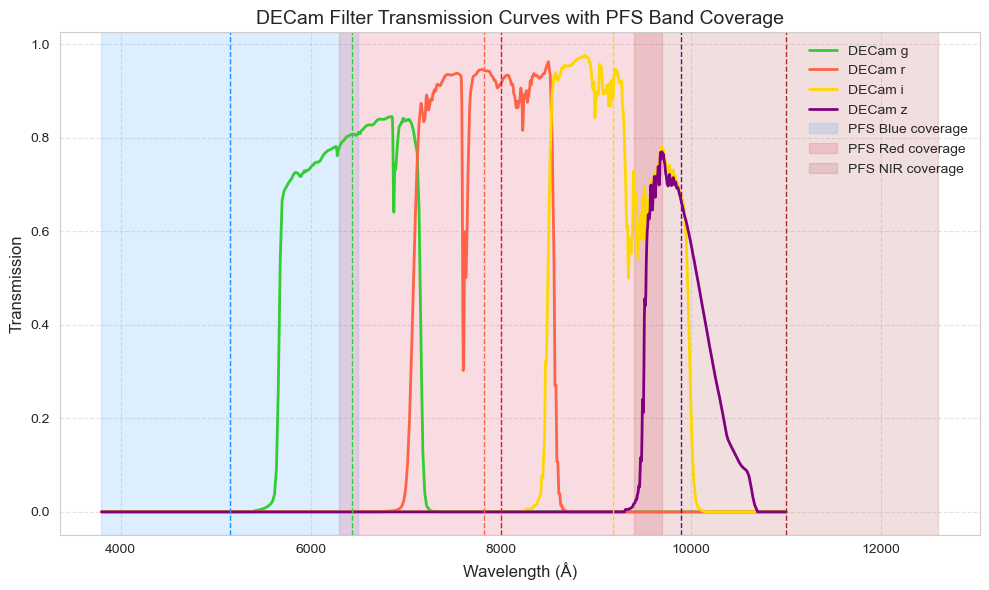

In [40]:
# Plot DECam transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='DECam g', color='limegreen', lw=2)
plt.plot(wav, filter_r, label='DECam r', color='tomato', lw=2)
plt.plot(wav, filter_i, label='DECam i', color='gold', lw=2)
plt.plot(wav, filter_z, label='DECam z', color='purple', lw=2)

# Plot CWL for Decam filters
plt.axvline(lam_eff_g, color='limegreen', ls='--', lw=1)
plt.axvline(lam_eff_r, color='tomato', ls='--', lw=1)
plt.axvline(lam_eff_i, color='gold', ls='--', lw=1)
plt.axvline(lam_eff_z, color='purple', ls='--', lw=1)

# Add shaded regions for PFS arms
for name, info in pfs_bands.items():
    x_min, x_max = info['range']
    plt.axvspan(x_min, x_max, color=info['color'], alpha=0.15, label=f"{name} coverage")
    plt.axvline(info['cwl'], color=info['color'], ls='--', lw=1)

# Plot formatting
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Transmission', fontsize=12)
plt.title('DECam Filter Transmission Curves with PFS Band Coverage', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
L_bol = peak_luminosity_1.copy() * u.erg / u.s
print(f"L_bol shape: {L_bol.shape}")

# Source distance
dL = events["S190521g"]["dL"] * u.Mpc
dL = dL.to(u.cm)

# Redshift
z = events["S190521g"]["redshift"]

# Effective wavelengths (Å)
eff_wavelengths = {
    'ZTF_g': 4746.48,
    'ZTF_r': 6185.20,

}

# Runnoe et al. (2012) correction factors
runnoe_coeffs = {
    3000: {'C': 5.2},
    5100: {'C': 8.1},
}

def L_lambda_from_Lbol(Lbol, lam_eff):
    """Compute λLλ from Lbol using nearest Runnoe correction factor."""
    ref_wavelength = min(runnoe_coeffs.keys(), key=lambda w: abs(w - lam_eff))
    C = runnoe_coeffs[ref_wavelength]['C']
    return Lbol / C  # λLλ in erg/s

# Constants
c = 2.99792458e18  # speed of light in Å/s

# To Store results
magnitudes = {band: np.zeros(L_bol.shape) for band in eff_wavelengths.keys()}

# Main computation
for i in range(L_bol.shape[0]):      
    Lbol = L_bol[i]

    for band, lam in eff_wavelengths.items():
        # λLλ (erg/s)
        L_lam = L_lambda_from_Lbol(Lbol, lam)

        # Lν (erg/s/Hz)
        L_nu = L_lam * (lam / c)

        # Fν at Earth (erg/s/cm²/Hz)
        F_nu = L_nu / (4 * np.pi * dL**2 * (1 + z))
        print(F_nu)

        # AB magnitude
        m_AB = -2.5 * np.log10(F_nu.value) - 48.6

        # Store result
        magnitudes[band][i] = m_AB

print("Estimated observed AB magnitudes:")
for band, mags in magnitudes.items():
    print(f"{band:10s}  mean={np.nanmean(mags):6.2f}  min={np.nanmin(mags):6.2f}  max={np.nanmax(mags):6.2f}")

rows = []
for i in range(L_bol.shape[0]):
    row = {'event': i}
    for band in magnitudes.keys():
        row[band] = magnitudes[band][i]
    rows.append(row)

mag_df = pd.DataFrame(rows)
print("\nDataFrame shape:", mag_df.shape)
mag_df

L_bol shape: (1,)
4.567060420863327e-28 erg / (s cm2)
5.95139600611903e-28 erg / (s cm2)
Estimated observed AB magnitudes:
ZTF_g       mean= 19.75  min= 19.75  max= 19.75
ZTF_r       mean= 19.46  min= 19.46  max= 19.46

DataFrame shape: (1, 3)


,event,ZTF_g,ZTF_r
0,0,19.750908,19.463453


In [42]:
def mags_from_Lbol(L_bol_array, lam_eff, dL_cm, z):
    """Return AB magnitude array for a given band."""
    # 1. λLλ (erg/s)
    L_lam = L_lambda_from_Lbol(L_bol_array, lam_eff)
    
    # 2. Lν = Lλ * (λ / c)
    L_nu = L_lam * (lam_eff / c)
    
    # 3. Fν = Lν / (4π dL²)
    F_nu = L_nu / (4 * np.pi * dL_cm**2 * (1 + z))
    
    # 4. Convert to AB magnitude
    m_AB = -2.5 * np.log10(F_nu.value) - 48.6
    return m_AB


lam_ztf_g = eff_wavelengths['ZTF_g']
lam_ztf_r = eff_wavelengths['ZTF_r']


# Lightcurves


PLot lightcurves

In [43]:
sig_start_times_1, peak_time_1, end_times_1

(array([20.]), array([40.]), 79.62247208713413)

In [44]:
%%time
sns.set_style("whitegrid")  

i = 0
event = list(events.keys())[0]
print(event) 

times_1 = np.array([sig_start_times_1[0], peak_time_1[0], end_times_1])

t_rise_1, t_fall_1, lumi_rise_1, lumi_fall_1 = light_curve_model(times_1, peak_luminosity_1)




# QSO SED
mag_rise_1_ztf_g_qso = mags_from_Lbol(lumi_rise_1, lam_ztf_g, dL, z)
mag_fall_1_ztf_g_qso = mags_from_Lbol(lumi_fall_1, lam_ztf_g, dL, z)
mag_rise_1_ztf_r_qso = mags_from_Lbol(lumi_rise_1, lam_ztf_r, dL, z)
mag_fall_1_ztf_r_qso = mags_from_Lbol(lumi_fall_1, lam_ztf_r, dL, z)


S190521g
CPU times: user 787 µs, sys: 612 µs, total: 1.4 ms
Wall time: 3.23 ms


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_43476/3482932097.py:13: RuntimeWarning: divide by zero encountered in log10
  m_AB = -2.5 * np.log10(F_nu.value) - 48.6


In [45]:
def f(mag):
    return 10**(-(mag+48.6)/2.5)

m1 = 19.1  
m2 = mag_rise_1_ztf_g_qso.copy()  
m3 = mag_fall_1_ztf_g_qso.copy()  
m1_ = 18.9
m2_ = mag_rise_1_ztf_r_qso.copy()
m3_ = mag_fall_1_ztf_r_qso.copy()

# Convert mags to flux (in arbitrary units)
flux1 = f(m1)
flux2 = f(m2)
flux3 = f(m3)
flux1_ = f(m1_)
flux2_ = f(m2_)
flux3_ = f(m3_)

# Sum the fluxes
flux_total1 = flux1 + flux2
flux_total2 = flux1 + flux3
flux_total1_ = flux1_ + flux2_
flux_total2_ = flux1_ + flux3_

# Convert back to magnitude
m_total1 = -2.5 * np.log10(flux_total1) - 48.6
m_total2 = -2.5 * np.log10(flux_total2) - 48.6
m_total1_ = -2.5 * np.log10(flux_total1_) - 48.6
m_total2_ = -2.5 * np.log10(flux_total2_) - 48.6


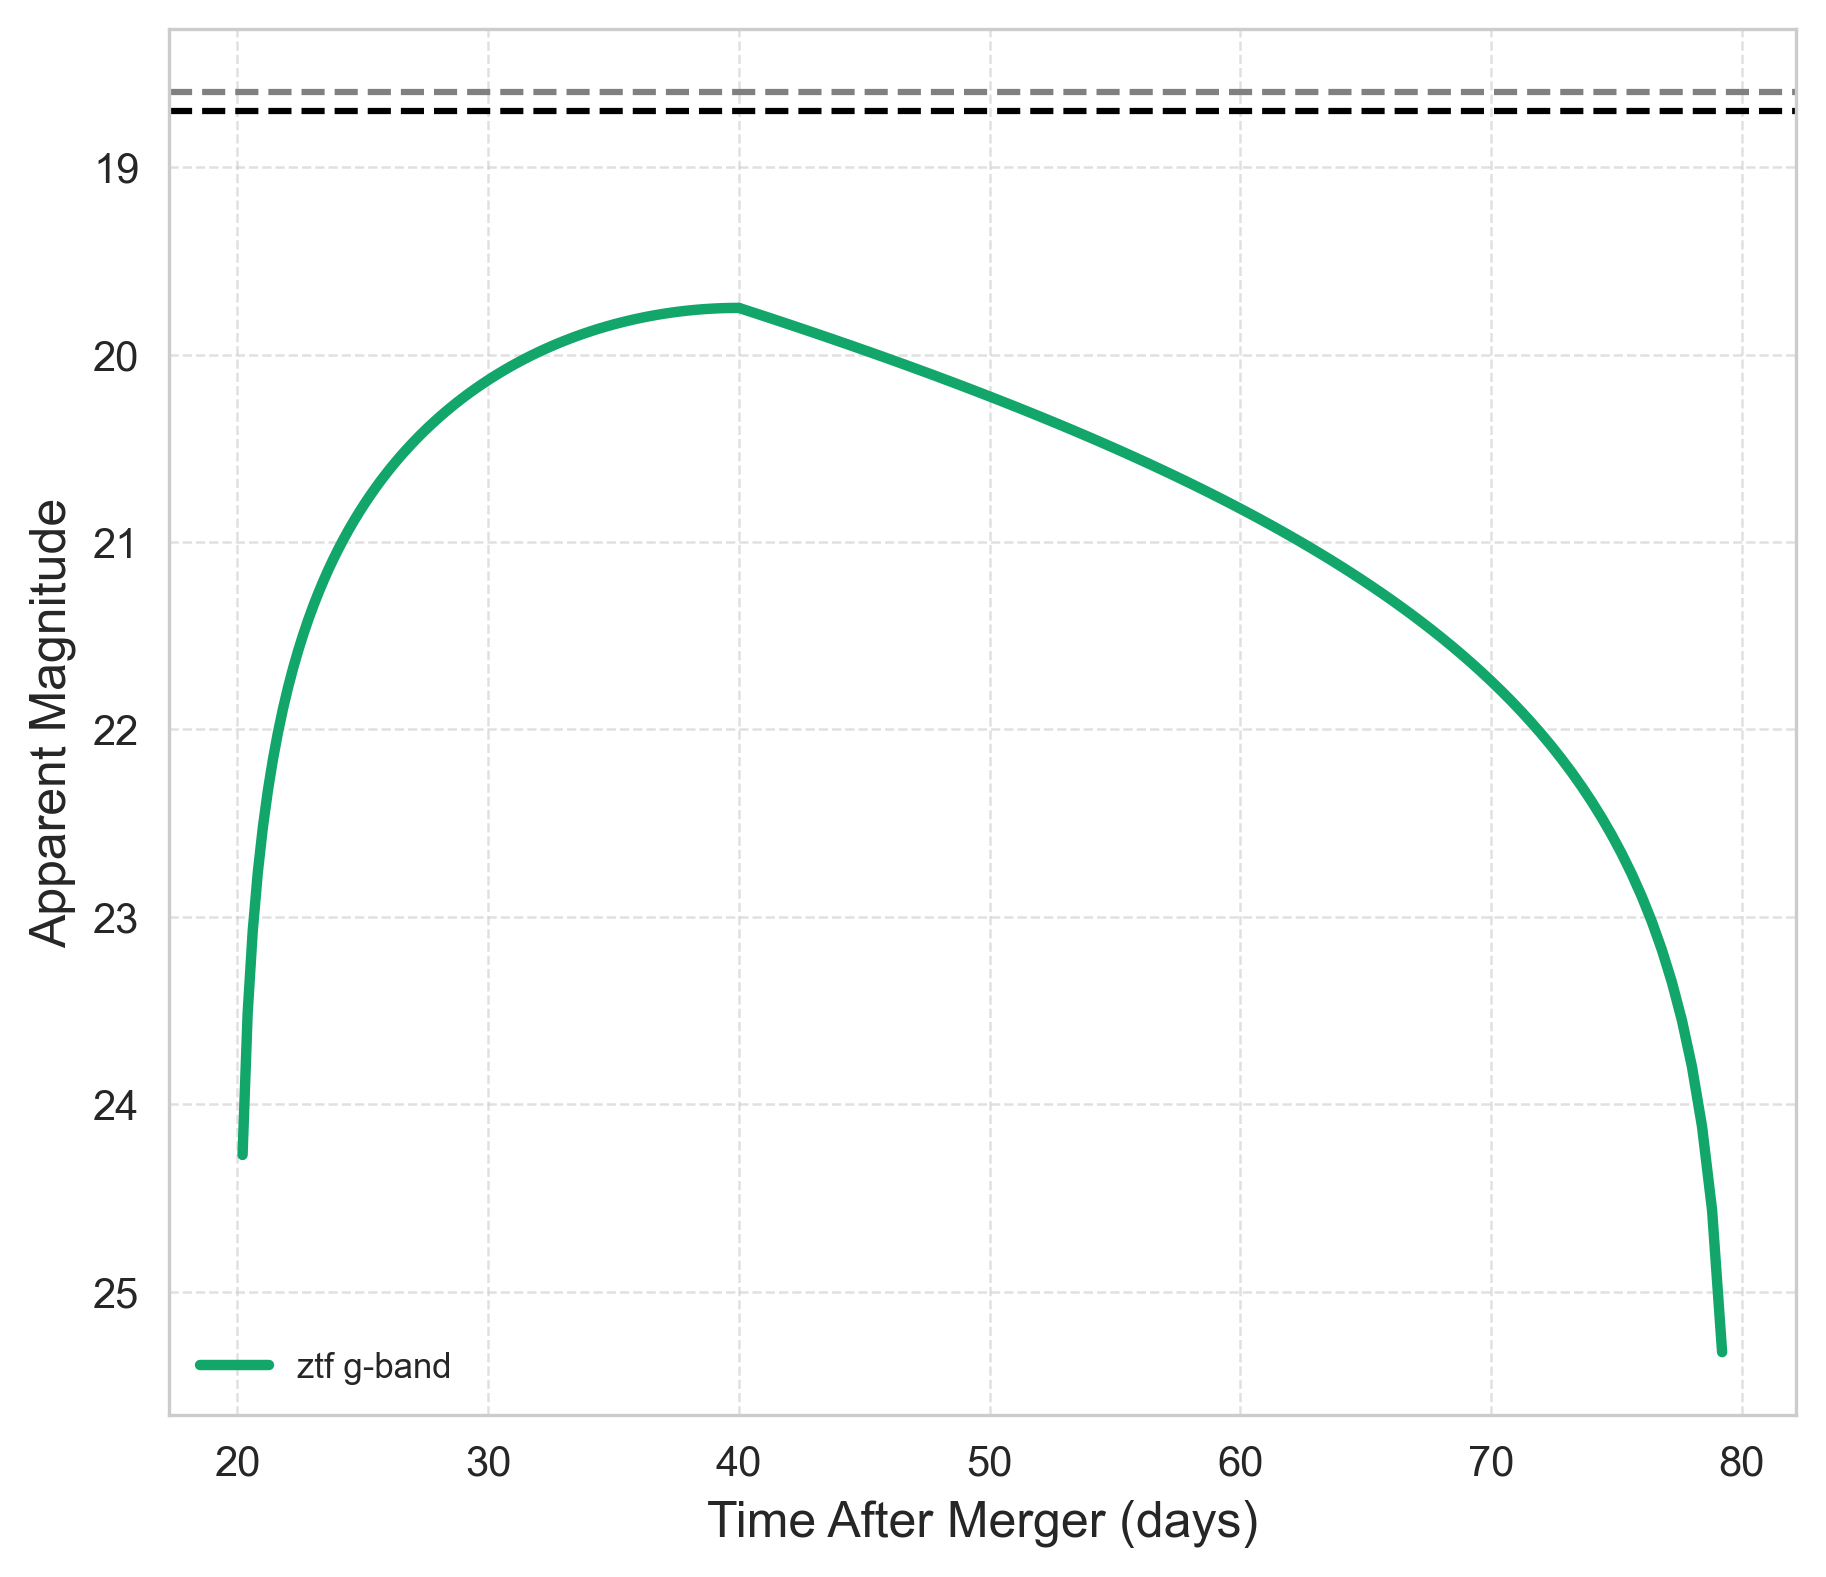

In [46]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)  # 1 row, 2 columns
ax.plot(t_rise_1, m2, color="#12A66B", linewidth=2.5, label='ztf g-band')#, linestyle=':', )
ax.plot(t_fall_1, m3, color='#12A66B', linewidth=2.5)#, linestyle=':')


#ax.plot(t_rise_1, m_total1_, color='#D81B60', linewidth=2.5, label='ztf r-band')#, linestyle='--', )
#ax.plot(t_fall_1, m_total2_, color='#D81B60', linewidth=2.5)#, linestyle='--')
colors = {'g': '#D81B60', 'r': '#1E88E5', 'i': '#FFC107', 'z': '#004D40'}



ax.axhline(y=18.6, color='gray', linestyle='--', linewidth=1.5)
ax.axhline(y=18.7, color='black', linestyle='--', linewidth=1.5)

ax.set_xlabel("Time After Merger (days)", fontsize=12)
ax.set_ylabel("Apparent Magnitude", fontsize=12)

ax.legend( frameon=False, fontsize='small', loc='best')
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.invert_yaxis() 

#ax.set_ylim(19.4, 18.6)

plt.savefig(f'lightcurve_{event}.jpeg', bbox_inches='tight', dpi=300)
plt.show()

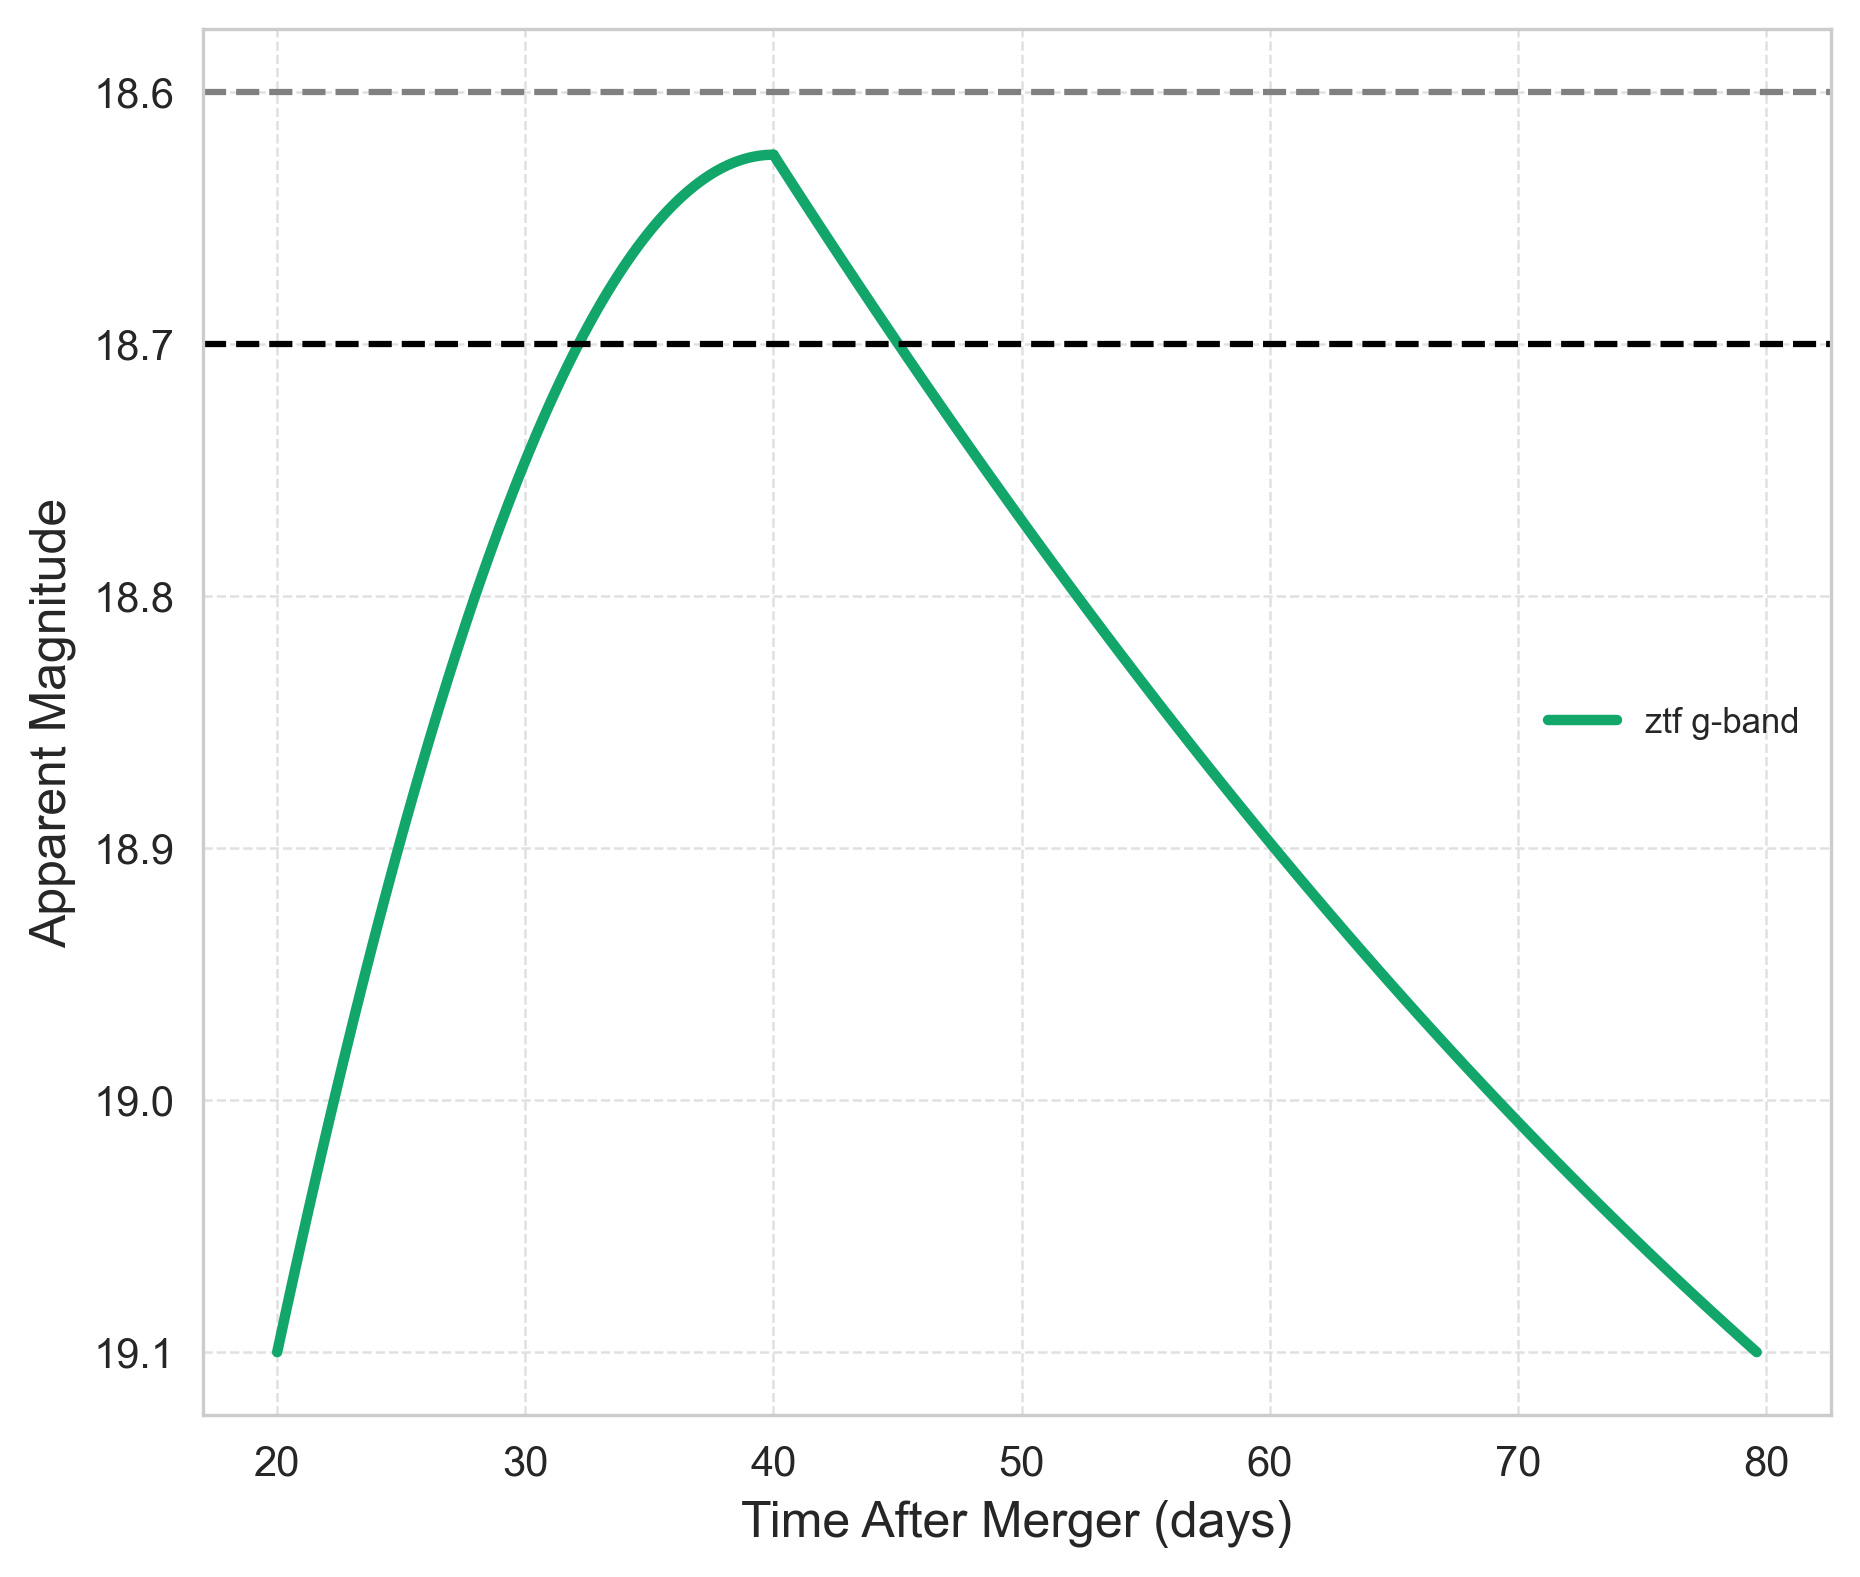

In [47]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)  # 1 row, 2 columns
ax.plot(t_rise_1, m_total1, color="#12A66B", linewidth=2.5, label='ztf g-band')#, linestyle=':', )
ax.plot(t_fall_1, m_total2, color='#12A66B', linewidth=2.5)#, linestyle=':')


#ax.plot(t_rise_1, m_total1_, color='#D81B60', linewidth=2.5, label='ztf r-band')#, linestyle='--', )
#ax.plot(t_fall_1, m_total2_, color='#D81B60', linewidth=2.5)#, linestyle='--')
colors = {'g': '#D81B60', 'r': '#1E88E5', 'i': '#FFC107', 'z': '#004D40'}



ax.axhline(y=18.6, color='gray', linestyle='--', linewidth=1.5)
ax.axhline(y=18.7, color='black', linestyle='--', linewidth=1.5)

ax.set_xlabel("Time After Merger (days)", fontsize=12)
ax.set_ylabel("Apparent Magnitude", fontsize=12)

ax.legend( frameon=False, fontsize='small', loc='best')
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.invert_yaxis() 

#ax.set_ylim(19.4, 18.6)

plt.savefig(f'lightcurve_{event}.jpeg', bbox_inches='tight', dpi=300)
plt.show()

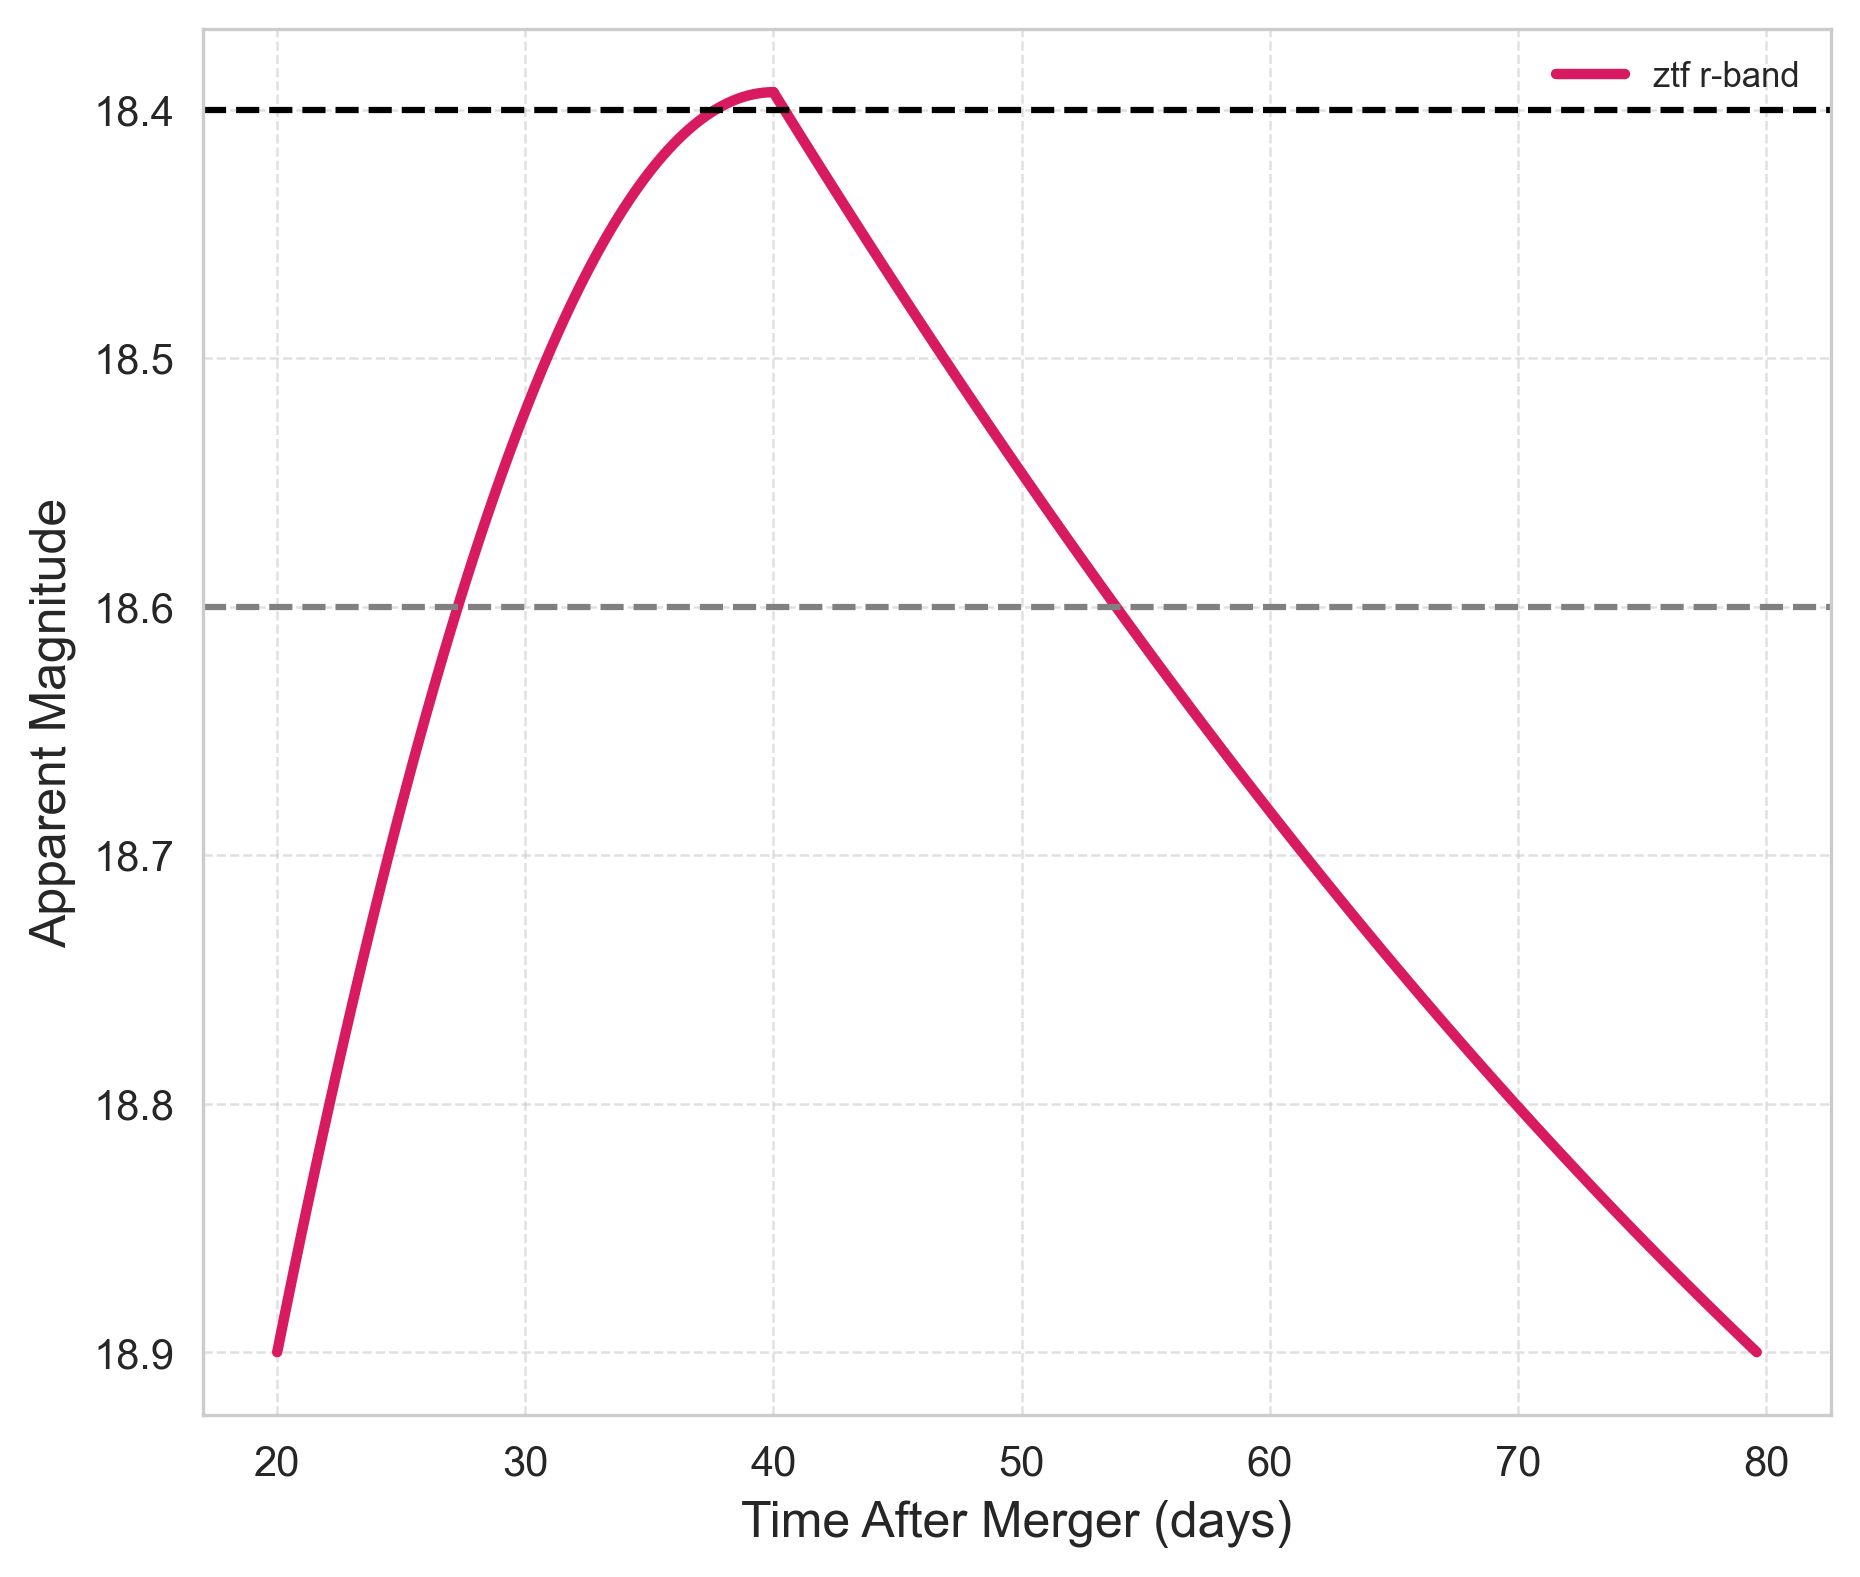

In [48]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)  # 1 row, 2 columns

ax.plot(t_rise_1, m_total1_, color='#D81B60', linewidth=2.5, label='ztf r-band')#, linestyle='--', )
ax.plot(t_fall_1, m_total2_, color='#D81B60', linewidth=2.5)#, linestyle='--')
colors = {'g': '#D81B60', 'r': '#1E88E5', 'i': '#FFC107', 'z': '#004D40'}



ax.axhline(y=18.6, color='gray', linestyle='--', linewidth=1.5)
ax.axhline(y=18.4, color='black', linestyle='--', linewidth=1.5)

ax.set_xlabel("Time After Merger (days)", fontsize=12)
ax.set_ylabel("Apparent Magnitude", fontsize=12)

ax.legend( frameon=False, fontsize='small', loc='best')
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.invert_yaxis() 

plt.savefig(f'lightcurve_{event}.jpeg', bbox_inches='tight', dpi=300)
plt.show()

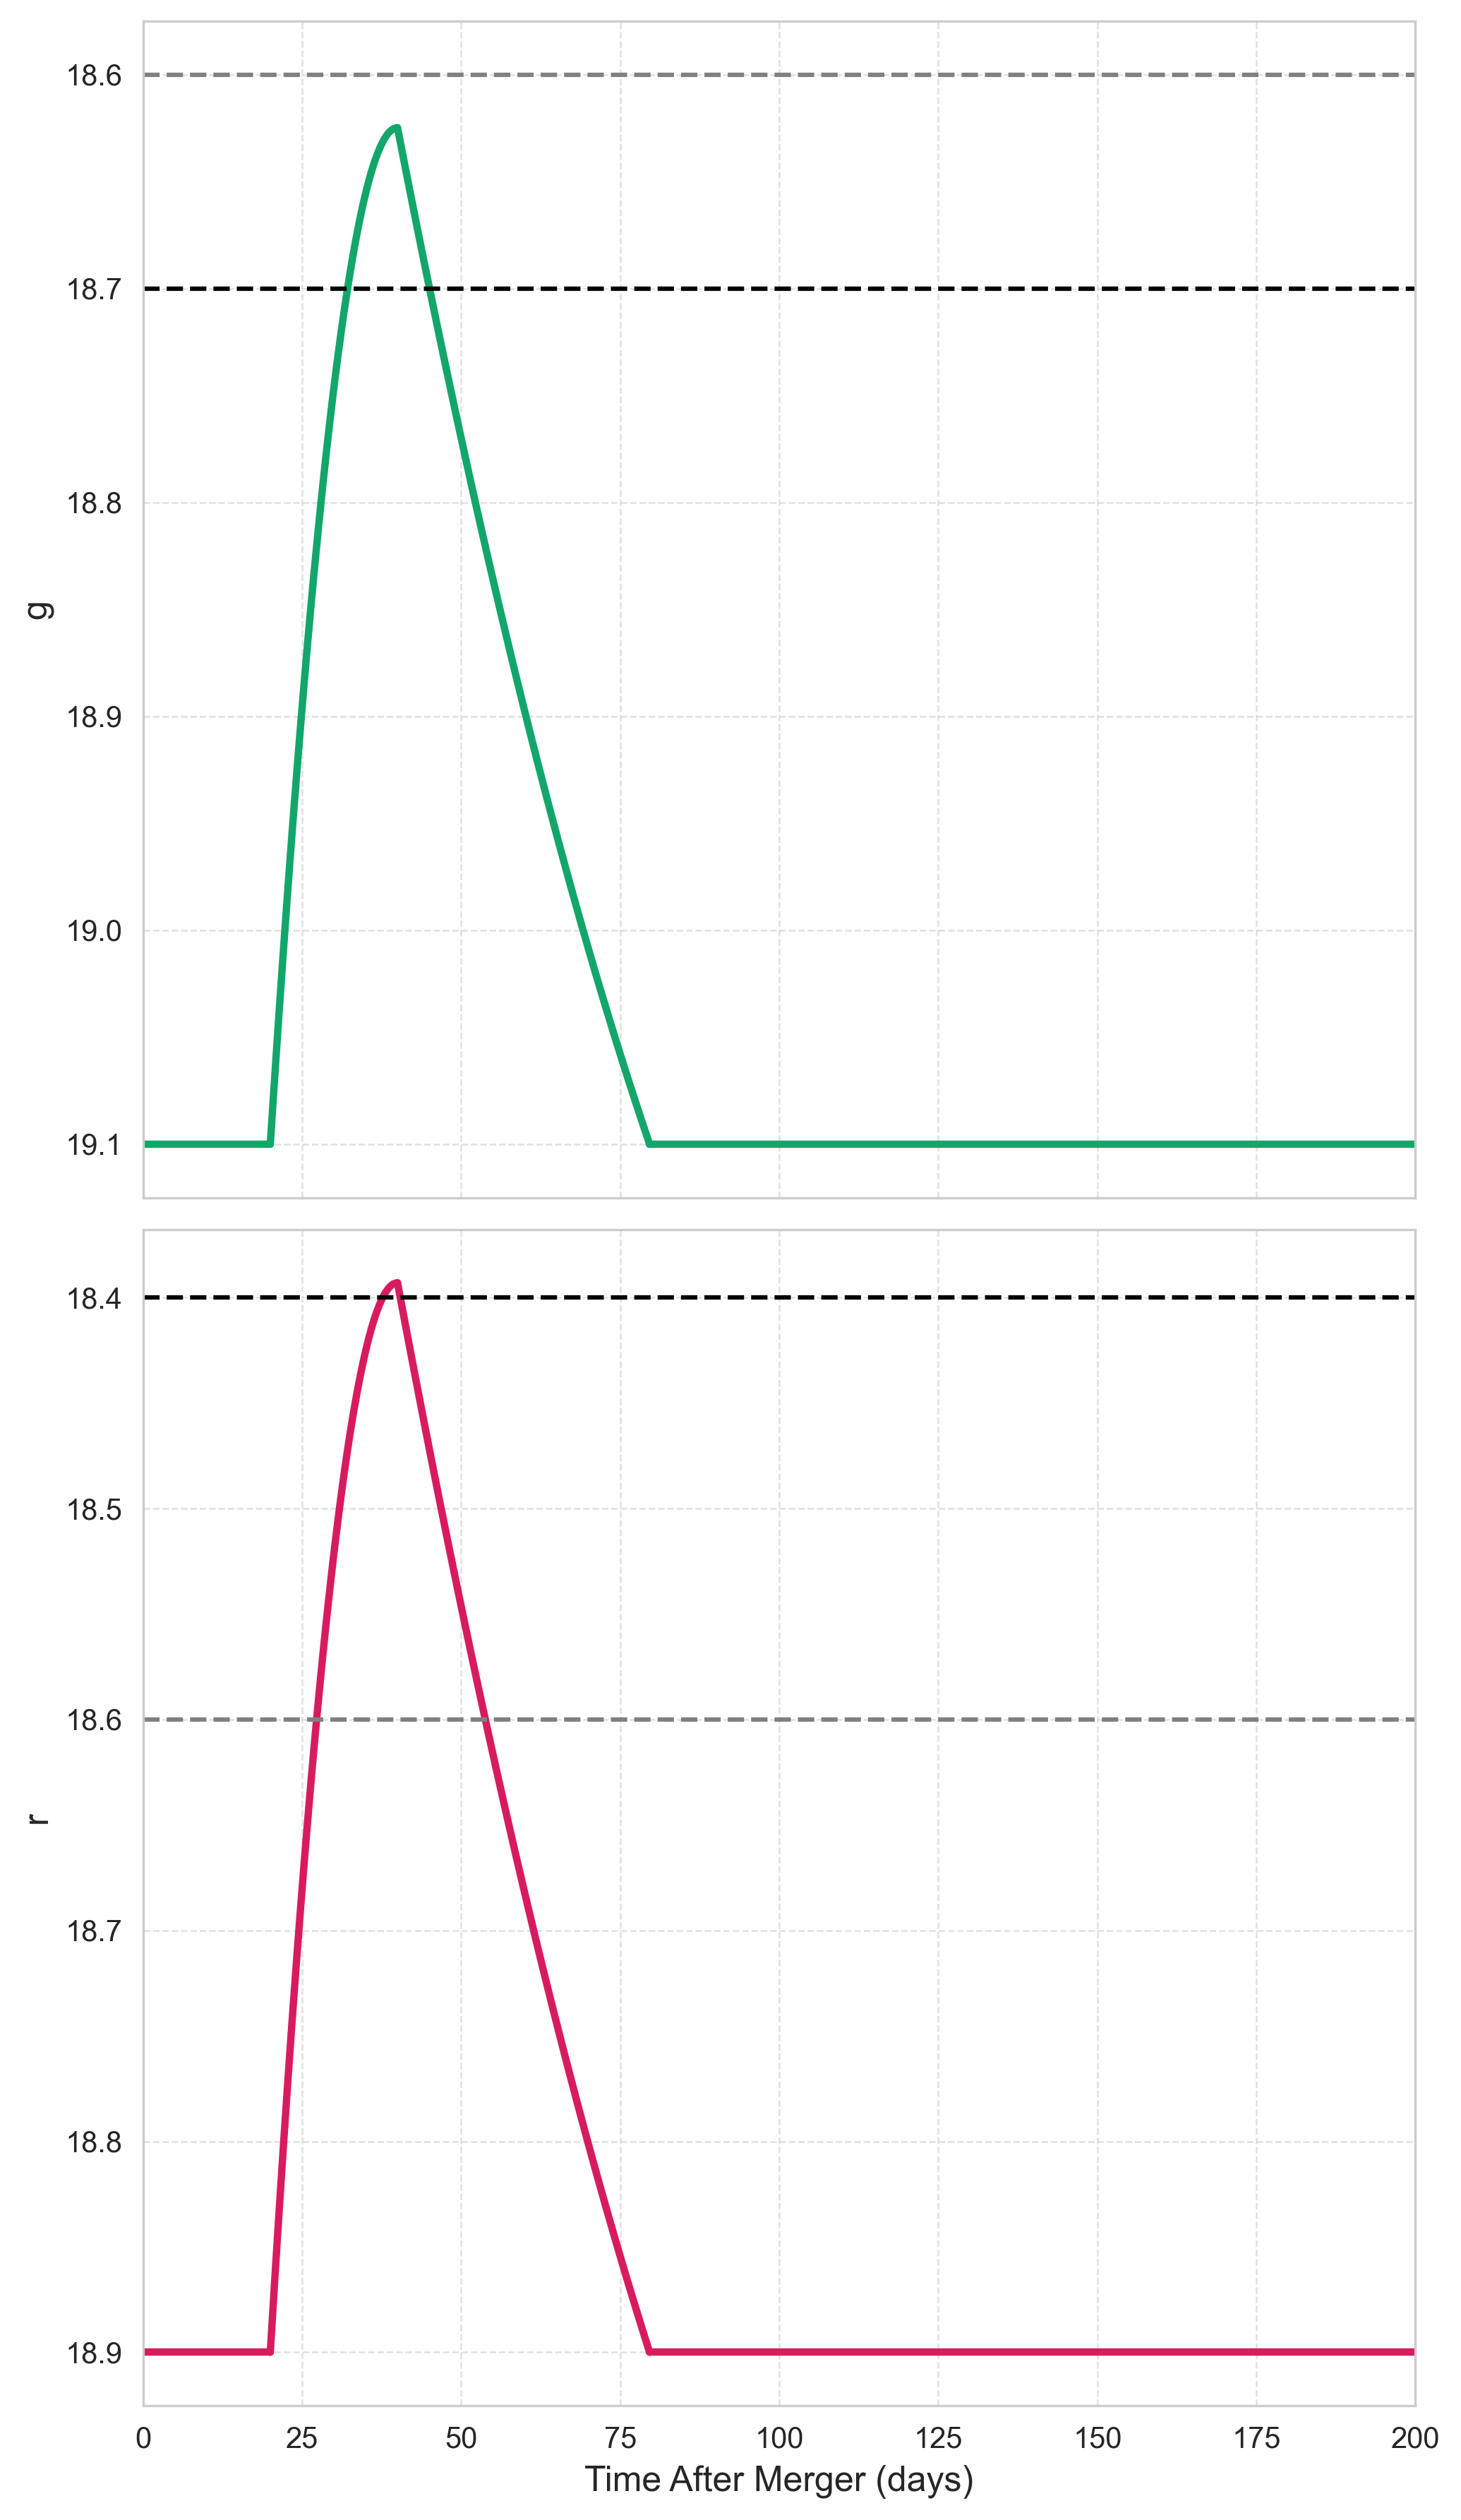

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 12), dpi=300, sharex=True)  # 2 rows, 1 column

# -----------------------------
# Top plot (g-band)
# -----------------------------
axes[0].plot(t_rise_1, m_total1, color="#12A66B", linewidth=2.5)#, label='ztf g-band')
axes[0].plot(t_fall_1, m_total2, color='#12A66B', linewidth=2.5)

axes[0].axhline(y=18.6, color='gray', linestyle='--', linewidth=1.5)
axes[0].axhline(y=18.7, color='black', linestyle='--', linewidth=1.5)

axes[0].plot([0, t_rise_1[0]], [19.1,19.1], color='#12A66B', linestyle='-', linewidth=2.5)
axes[0].plot([t_fall_1[-1], t_fall_1[-1] + 200], [19.1,19.1], color='#12A66B', linestyle='-', linewidth=2.5)

axes[0].set_ylabel("g", fontsize=12)
axes[0].grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
axes[0].invert_yaxis()

# -----------------------------
# Bottom plot (r-band)
# -----------------------------
axes[1].plot(t_rise_1, m_total1_, color='#D81B60', linewidth=2.5)#, label='ztf r-band')
axes[1].plot(t_fall_1, m_total2_, color='#D81B60', linewidth=2.5)

axes[1].axhline(y=18.6, color='gray', linestyle='--', linewidth=1.5)
axes[1].axhline(y=18.4, color='black', linestyle='--', linewidth=1.5)

axes[1].plot([0, t_rise_1[0]], [18.9,18.9], color='#D81B60', linestyle='-', linewidth=2.5)
axes[1].plot([t_fall_1[-1], t_fall_1[-1] + 200], [18.9,18.9], color='#D81B60', linestyle='-', linewidth=2.5)

axes[1].set_xlabel("Time After Merger (days)", fontsize=12)
axes[1].set_ylabel("r", fontsize=12)
axes[1].grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
axes[1].invert_yaxis()

axes[1].set_xlim(0, 200)

# -----------------------------
# Save and show
# -----------------------------
plt.tight_layout()
plt.savefig(f'lightcurve_{event}.jpeg', bbox_inches='tight', dpi=600)
plt.show()

In [50]:
L_bol = 10**45 # erg/s
C_bol = 5.2
lambda_ref = 3000  # Angstroms
dL = 2418.6#2502.2  # Mpc
z = 0.438
lambda_obs_ztf_g = 4746.48

In [51]:
L_lambda = L_bol / (C_bol * lambda_ref * 1e-8)  # erg/s/cm
L_lambda

6.41025641025641e+48

In [52]:
f_lambda = L_lambda / (4 * np.pi * (dL * 3.086e24)**2 * (1 + z)) 
f_lambda 

6.367760359376859e-09

In [53]:
f_nu = f_lambda * (lambda_obs_ztf_g * 1e-8)**2 / 3e10  # erg/s/cm^2/Hz
f_nu

4.781991136704027e-28

In [54]:
mag_ztf_r = -2.5 * np.log10(f_nu) - 48.6
mag_ztf_r

19.700978082932515

In [55]:
def f(mag):
   return 10**(-(mag+48.6)/2.5)
wavelength_g_eff = 4746.48  # ZTF g band effective center
f_nu = f(18.7) - f(19.1)    # difference magnitude at peak
f_lambda = 3e18 * f_nu / wavelength_g_eff**2
L_lambda = f_lambda * 4 * np.pi * (2418.6e6*3.086e+18)**2   # monochromatic luminosity of the AGN at z=0.438, DL=2418.6 Mpc
L_bol = 5.2 * L_lambda * wavelength_g_eff/(1+0.438) # bolometric luminosity corrected by the factor at 3000 angstrom
print(np.log10(L_bol))  # should output 44.8, Graham et al. (2020) show ~45
print(f_nu)

44.77291285168506
3.705006635147506e-28


In [56]:
def f(mag):
    return 10**(-(mag+48.6)/2.5)

wavelength_g_eff = 4746.48  # ZTF g band effective center
f_nu = (f(18.7) - f(19.1))/(1+0.438)    # difference magnitude at peak
f_lambda = 3e18 * f_nu / wavelength_g_eff**2
L_lambda = f_lambda * 4 * np.pi * (2418.6e6*3.086e+18)**2   # monochromatic luminosity of the AGN at z=0.438, DL=2418.6 Mpc
L_bol = 8.1 * L_lambda * wavelength_g_eff # bolometric luminosity corrected by the factor at 3000 angstrom; see Table 2 in 2012MNRAS.422..478R
print(np.log10(L_bol))  # should output 44.8, Graham et al. (2020) show ~45
print(f_nu)

44.96539452692891
2.5764997462778208e-28
